In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("ALL.csv")

Testing factor alert_relevance_weighted_positive_sentiment
Sharpe ratio: 0.06704575329359781


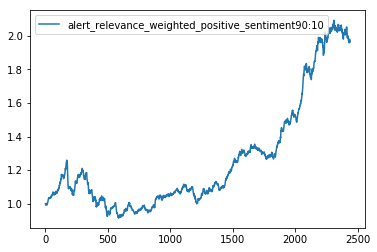

In [21]:
# orchesration function
def run_single_backtest(df):
    df = df[(df.returnsOpenNextMktres10 < 0.4) & (df.returnsOpenNextMktres10 > -0.4)]
    df = df.reset_index(drop=True)
    if 'universe' not in df.columns:
        df['universe'] = [1 for i in range(len(df))]
    assert('returnsOpenNextMktres10' in df.columns)
    count = 0
    count_list = []
    curr_date = df.datetime[0]
    for date in df.datetime:
        if date == curr_date:
            count+=1
        else:
            count_list.append(count)
            curr_date = date
            count = 1
    count_list.append(count)
    partition_rows = [0] + list(np.cumsum(count_list))
    exclude_list = ['assetCode', 'month', 'week', 'datetime', 'returnsOpenNextMktres10']
    for factor in ['alert_relevance_weighted_positive_sentiment']:
        if factor not in exclude_list:
            print('Testing factor '+factor)
            single_factor_result = backtest_single_score( df, df[factor], partition_rows, count_list, offset = 60 )
            plot_returns(single_factor_result[0], factor)
            plt.show()

# Calculate the returns and Sharpe ratio of long-short portfolio for a single factor 
def backtest_single_score( df, score, partition_rows, count_list, num_group = 5, offset = 0 ):
    returns = []
    for i in range(offset,len(count_list)):
        l = partition_rows[i]
        r = partition_rows[i+1]
        stock_ret_i = df['returnsOpenNextMktres10'][l:r]
        score_i = score[l:r]
        index_i = np.argsort(score_i)+l
        tradeable_ret_i = stock_ret_i*df['universe'][l:r]
        # top 90 vs bottom 10
        port_ret_i = np.mean(tradeable_ret_i[index_i[-4*(r-l)//num_group:]])-np.mean(tradeable_ret_i[index_i[:4*(r-l)//num_group]])
        returns.append(port_ret_i)
    print("Sharpe ratio:",np.mean(returns)/np.std(returns))
    return returns,np.mean(returns)/np.std(returns)

# Assume we can realize 10-day return in one day and rebalance every day
# Use all the return data
def plot_returns ( returns, label=""):
    net_value = [1.0]
    for ret in returns:
        net_value.append(net_value[-1]*(1+ret))
    plt.plot(net_value, label = label+"90:10")
    plt.legend()

run_single_backtest(df)

In [11]:
df.shape

(485498, 49)

In [88]:
int(1098 * 0.9)

988

In [30]:
# outlier removal
df = df[abs(df.returnsOpenNextMktres10) < 0.40]

In [31]:
def single_factor_helper(x, cutoff = 0.9):
    d = {}
    sorted_x = x.sort_values('alert_relevance_weighted_positive_sentiment').reset_index(drop=True)
    index = int(len(sorted_x) * cutoff)
    short_portfolio = np.mean(sorted_x['returnsOpenNextMktres10'][:index])
    long_portfolio = np.mean(sorted_x['returnsOpenNextMktres10'][index:])
    d['daily_return'] = long_portfolio - short_portfolio
    return pd.Series(d, index=['daily_return'])

def single_factor_eva(df):
    factor_return = df.groupby('datetime').apply(single_factor_helper)
    print("Sharpe ratio:", factor_return.mean() / factor_return.std())


Sharpe ratio: daily_return    0.011337
dtype: float64


In [35]:
factor_return['cumsum'] = factor_return.daily_return.cumsum()

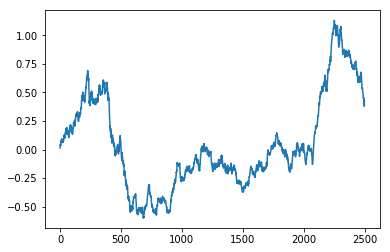

In [36]:
plt.plot(list(factor_return['cumsum']), label = "90:10")